# Serial debugging example

This example shows how you can use write and read comm configurations to save communication data from a mpi-enabled run to disk, and then debug that run in serial inside a jupyter notebook.

This example is being run on April 22nd, 2022. It uses internal, unstable APIs and may not work for future versions of the code.

First let's import the packages we will use below.

In [1]:
import pace.util
import pace.driver
import fv3core.stencils.d2a2c_vect
import yaml
import dacite
import copy
import subprocess
import matplotlib.pyplot as plt  # pip install matplotlib

We will base this example on a baroclinic c12 configuration using 6 ranks, but this same code can run with any configuration, even one that was run at scale on an HPC system.

## Step 1: writing communication data

First we modify the configuration into one that will write all communications on rank 0 into a directory called "comm". This could be modified to write communications for more ranks by adding them to the "ranks" list.

In [2]:
with open("../configs/baroclinic_c12.yaml", "r") as f:
    base_config = yaml.safe_load(f)

In [3]:
write_config = copy.deepcopy(base_config)
write_config["comm_config"] = {
    "type": "write",
    "config": {
        "path": "comm",
        "ranks": [0]
    }
}
# diagnostics involve communication that interacts with the disk, must be disabled
write_config.pop("diagnostics_config")
with open("driver_write_config.yaml", "w") as f:
    yaml.dump(write_config, f)

With this configuration written to disk, we run:

```bash
mpirun -n 6 python3 -m pace.driver.run driver_write_config.yaml
```

This produces output files in a "comm" directory. You could instead run a "write" configuration through another method like submitting a batch job to an HPC system. The important part is to recover the "comm" directory that gets written by this configuration, so it can be referenced in our read configuration below. Here we see it includes data for rank 0 only.

In [4]:
%%bash
ls comm

comm_0.pkl


## Step 2: reading communication data into a Driver object

We can take the "write" configuration and modify its comm config to create a "read" configuration. The rank used can be any rank which has data inside the communication cache indicated by the path.

In [5]:
read_config = copy.deepcopy(write_config)
read_config["comm_config"] = {
    "type": "read",
    "config": {
        "path": "comm",
        "rank": 0
    }
}

From this configuration, we can create a driver object, and start inspecting its state. Let's take a look at the evolution of the wind and pressure fields over the first two timesteps.

Keep in mind that we will be looking at rank 0, whose y-axis exactly follows latitude lines and x-axis approximately follows longitude lines.

In [6]:
driver = pace.driver.Driver(config=pace.driver.DriverConfig.from_dict(read_config))

In [7]:
dycore_state = driver.state.dycore_state
# make a copy of the initial state to do experiments with later
initial_state = copy.deepcopy(dycore_state)

We'll also define a plot helper routine to make it easier to quickly inspect different variables, without copying code. We'll look at level 50 of the models' 79 levels, which lies somewhere in the middle of the troposphere.

In [8]:
def plot(state, varname):
    data = getattr(state, varname)
    # temporary workaround for bug where view goes out-of-sync with storage
    data.view._data = data.storage.data
    plt.figure(figsize=(5, 5))
    # imshow by default puts x on the left and y on the bottom axis, so we transpose
    # view by default selects the compute domain, ignoring halos
    im = plt.imshow(data.view[:, :, 50].T)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(im)
    plt.title(f"{varname} ({data.units})")

First we'll look at the initial winds. Notice that for the winds only `u` and `v`, which contain the d-grid covariant winds, have data - this is intentional, as it is the prognostic variable used by the model. The C-grid winds in `uc`/`vc` will be diagnosed from these and then marched forward by half a timestep, before being used to advect the d-grid variables.

This initialization case involves zonally uniform zonal winds with no meridional winds, so it makes sense that `v` is initialized with near-zero values.

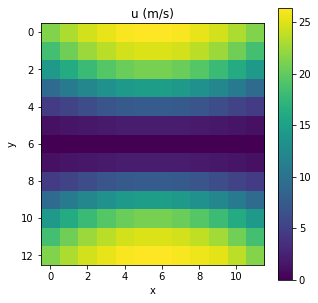

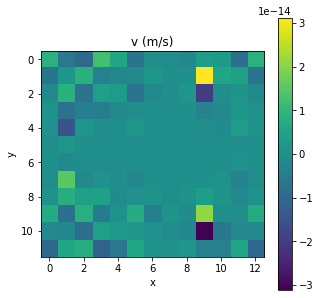

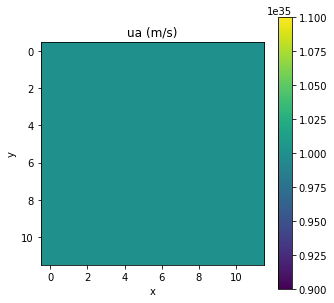

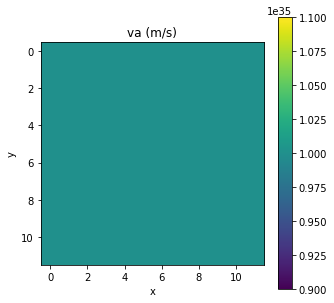

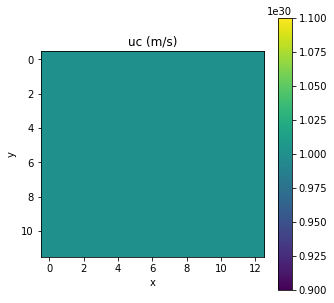

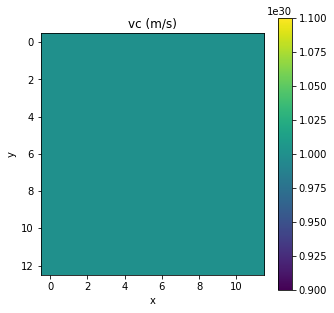

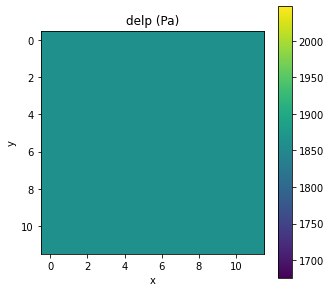

In [9]:
plot(dycore_state, "u")
plot(dycore_state, "v")
plot(dycore_state, "ua")
plot(dycore_state, "va")
plot(dycore_state, "uc")
plot(dycore_state, "vc")
plot(dycore_state, "delp")

We can step the model forward by one timestep, and see how this affects the evolution of the model state.

In [10]:
driver.step(timestep=driver.config.timestep)

FV Setup
Adjust pt
DynCore
TracerAdvection
Remapping
Omega
Neg Adj 3
CubedToLatLon


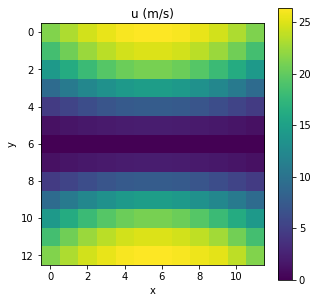

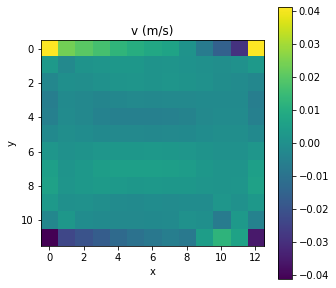

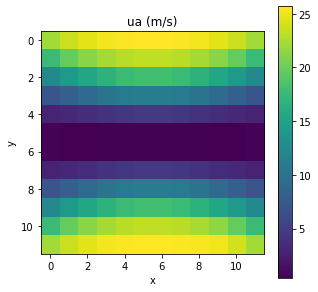

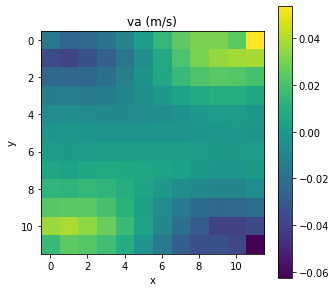

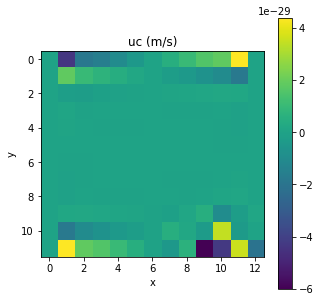

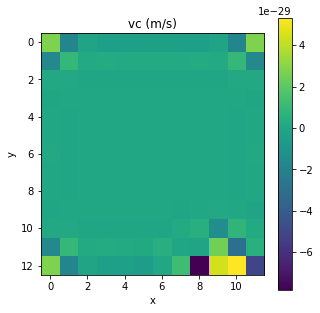

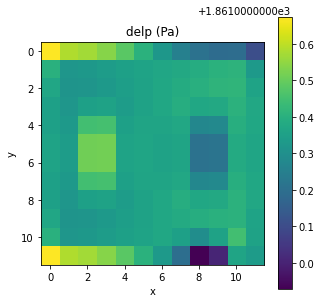

In [11]:
plot(dycore_state, "u")
plot(dycore_state, "v")
plot(dycore_state, "ua")
plot(dycore_state, "va")
plot(dycore_state, "uc")
plot(dycore_state, "vc")
plot(dycore_state, "delp")

`u` appears mostly unchanged, since its initial values are quite significant and are most of the signal in the plot. The changes to `v` are quite small.

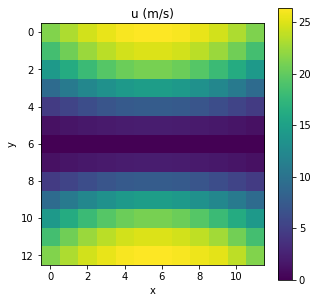

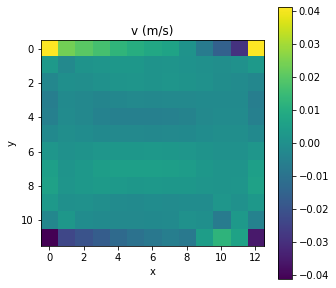

In [12]:
plot(dycore_state, "u")
plot(dycore_state, "v")

The other wind variables now contain their intermediate values used to evolve the model forward. `ua` and `va` contain the contravariant winds defined on the a-grid, in other words the winds in directions perpendicular to finite volume gridcell faces defined on cell centers.

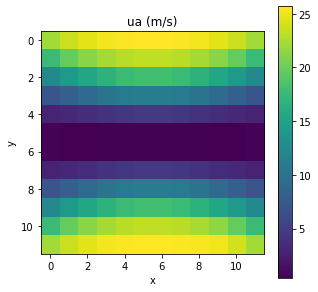

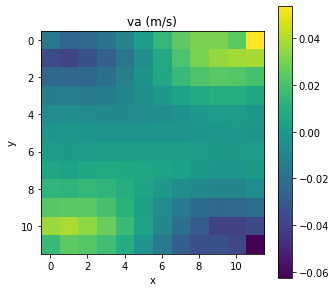

In [13]:
plot(dycore_state, "ua")
plot(dycore_state, "va")

`uc` and `vc` do not make much sense, comparing with the winds above. Note the very small magnitudes (1e-29 scaling on the colorbar). I don't have an explanation - it's likely these variables have been repurposed for a secondary use after they are no longer needed in the model, for memory efficiency reasons. In gt4py and dace we do not need this kind of manual memory optimization, and we are slowly refactoring re-usage of variables over time.

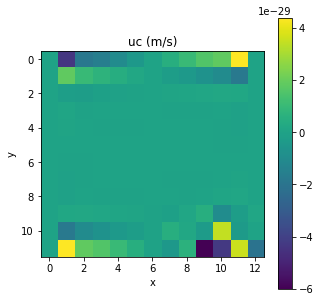

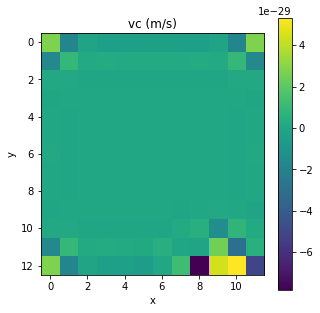

In [14]:
plot(dycore_state, "uc")
plot(dycore_state, "vc")

And finally, we can see the evolved pressure thickness field.

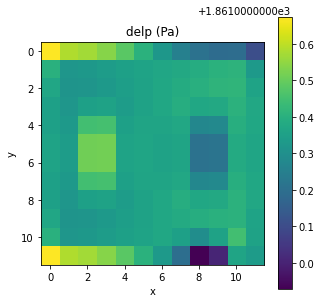

In [15]:
plot(dycore_state, "delp")

## Inspecting behavior of an internal component

The reader-comm driver will play back communications exactly as they occurred when the reference data was created, so we cannot run communication code different from what happened at that time. But we can run code that does not rely on communications. For example, let's look at how the d-grid winds (`u` and `v`) are remapped to a-grid and c-grid winds by `DGrid2AGrid2CGridVectors`.

In [16]:
d2a2c = fv3core.stencils.d2a2c_vect.DGrid2AGrid2CGridVectors(
    stencil_factory=driver.stencil_factory,
    grid_data=driver.state.grid_data,
    nested=False,
    grid_type=0,
    dord4=True
)

In [17]:
remap_state = copy.deepcopy(initial_state)

In [18]:
# need temporaries for c-grid contravariant wind multiplied by timestep
utc = driver.quantity_factory.zeros(dims=[pace.util.X_DIM, pace.util.Y_DIM, pace.util.Z_DIM], units="m/s")
vtc = driver.quantity_factory.zeros(dims=[pace.util.X_DIM, pace.util.Y_DIM, pace.util.Z_DIM], units="m/s")
d2a2c(
    uc=remap_state.uc,
    vc=remap_state.vc,
    u=remap_state.u,
    v=remap_state.v,
    ua=remap_state.ua,
    va=remap_state.va,
    utc=utc,
    vtc=vtc
)

`u`, `ua`, and `uc` all look quite similar, since the magnitude of `u` is large and there is no component from `v` to factor in when converting between covariant and contravariant winds.

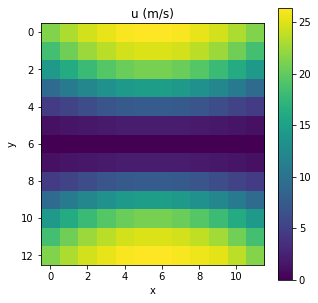

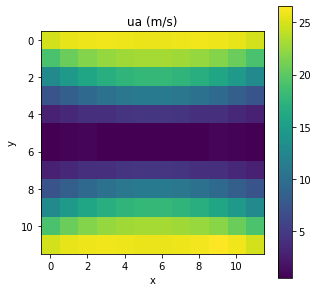

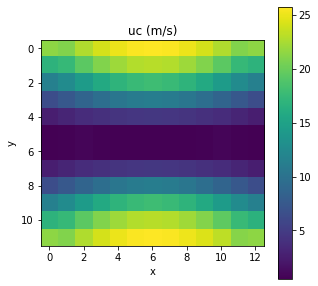

In [19]:
plot(remap_state, "u")
plot(remap_state, "ua")
plot(remap_state, "uc")

`v` is more interesting. While the initial wind has no projection onto the meridional direction (no covariant component in the meridional direction), it does have a contravariant component along this direction, as we see in `va`, the contravariant y-wind on the a-grid.

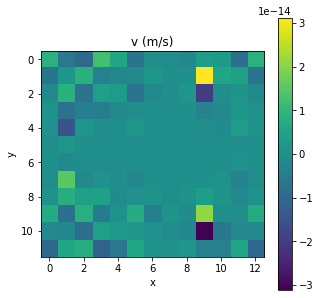

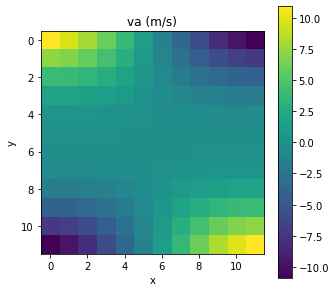

In [20]:
plot(remap_state, "v")
plot(remap_state, "va")

`vc` is even more interesting, as it contains the covariant wind on the c-grid, which at y-edges lies on the boundary of two tile faces. At this location, the wind borders on two different coordinate systems, and the covariant wind is not well-defined. Despite the covariant y-wind being zero on the entire tile (including the edge, if we considered only rank 0's coordinate system), it contains non-zero values at the tile edge where it has to consider the coordinate systems of neighboring tiles.

This is one of many examples where the FV3 code contains special logic for handling advection at tile edges.

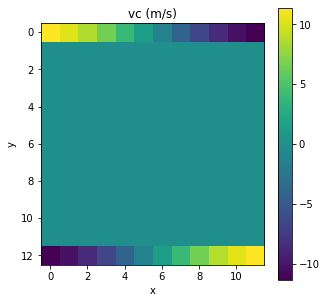

In [21]:
plot(remap_state, "vc")